# Gaussian Mixture Models
    Taylor Rubalcava

In [35]:
import numpy as np
from scipy import stats as st
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
import time

from sklearn.metrics import confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal

In [36]:
class GMM:
    # Problem 1
    def __init__(self, n_components, weights=None, means=None, covars=None):
        """
        Initializes a GMM.
        
        The parameters weights, means, and covars are optional. If fit() is called,
        they will be automatically initialized from the data.
        
        If specified, the parameters should have the following shapes, where d is
        the dimension of the GMM:
            weights: (n_components,)
            means: (n_components, d)
            covars: (n_components, d, d)
        """
        self.n_components = n_components
        self.weights = weights
        self.means = means
        self.covars = covars
    
    # Problem 2
    def component_logpdf(self, k, z):
        """
        Returns the logarithm of the component pdf. This is used in several computations
        in other functions.
        
        Parameters:
            k (int) - the index of the component
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the log pdf of the component at 
        """
        return np.log(self.weights[k]) + multivariate_normal.logpdf(z,self.means[k],self.covars[k])
        
    
    # Problem 2
    def pdf(self, z):
        """
        Returns the probability density of the GMM at the given point or points.
        
        Parameters:
            z ((d,) or (..., d) ndarray) - the point or points at which to compute the pdf
        Returns:
            (float or ndarray) - the value of the GMM pdf at z
        """
        total_probability = 0
        for i in range(self.n_components):
            total_probability += np.exp(self.component_logpdf(i,z))

        return total_probability

    
    # Problem 3
    def draw(self, n):
        """
        Draws n points from the GMM.
        
        Parameters:
            n (int) - the number of points to draw
        Returns:
            ((n,d) ndarray) - the drawn points, where d is the dimension of the GMM.
        """
        samples = []

        # Picking a model
        distributions = np.random.choice(self.n_components, size=n, p = self.weights)

        # Drawing from each of the distributions
        for model in distributions:
            samples.append(multivariate_normal.rvs(self.means[model],self.covars[model]))

        return np.array(samples)
            
    
    # Problem 4
    def _compute_e_step(self, Z):
        """
        Computes the values of q_i^t(k) for the given data and current parameters.
        
        Parameters:
            Z ((n, d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components, n) ndarray): an array of the computed q_i^t(k) values, such
                    that result[k,i] = q_i^t(k).
        """
        # Calculation l_i_k
        l_i_k = [self.component_logpdf(k,Z) for k in range(self.n_components)]
        L_i = np.max(l_i_k, axis = 0)
        return np.exp(l_i_k - L_i) / np.sum(np.exp(l_i_k - L_i), axis=0)

        
    # Problem 5
    def _compute_m_step(self, Z):
        """
        Takes a step of the expectation maximization (EM) algorithm. Return
        the updated parameters.
        
        Parameters:
            Z (n,d) ndarray): the data that is being used for training; d is the
                    dimension of the data.
        Returns:
            ((n_components,) ndarray): the updated component weights
            ((n_components,d) ndarray): the updated component means
            ((n_components,d,d) ndarray): the updated component covariance matrices
        """
        # Shape: (K,n)
        q_values = self._compute_e_step(Z)
        
        # New weights
        weights = (1/len(Z)) * np.sum(q_values, axis = 1)
        
        # Compute the new means
        # new_means = np.sum([q_values[i] * Z[i] for i in range(len(Z))], axis=0) / np.sum(q_values, axis = 1)
        new_means = [q_values[k] @ Z / np.sum(q_values[k]) for k in range(self.n_components)]
        
        # Compute the new covariances
        obs_centered = np.expand_dims(Z, 0) - np.expand_dims(new_means, 1)
        new_covars = np.einsum('Kn,Knd,KnD->KdD', q_values, obs_centered, obs_centered) / np.sum(q_values, axis=1).reshape(-1, 1, 1)

        return weights, np.array(new_means), new_covars
        
    # Problem 6
    def fit(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model by applying the Expectation Maximization algorithm until the
        parameters appear to converge.
        
        Parameters:
            Z ((n,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            self
        """
        # Checking if the GMMs parameters are uninitialized (set to None)
        # and if so, initializing them
        if self.weights is None:
            self.weights = np.full(self.n_components, 1/self.n_components)
        if self.means is None:
            # Choosing some random points from the data and using them to estimate the means
            self.means = Z[np.random.choice(Z.shape[0], self.n_components, replace=False)]
        if self.covars is None:
            # The covariance matricies can be initialized to the as diagonal matrices
            # based on the variance of the data
            variance_of_data_matrix = np.diag(np.var(Z, axis=0))
            # Stacking those matricies to get the n_components dimension
            self.covars = np.stack([variance_of_data_matrix for _ in range(self.n_components)], axis = 0)

        change = np.inf
        while change > tol and maxiter > 0:
            old_means = self.means
            old_covars = self.covars
            old_weights = self.weights
            
            self.weights, self.means, self.covars = self._compute_m_step(Z)

            change = (np.max(np.abs(self.weights - old_weights))
                        + np.max(np.abs(self.means - old_means))
                        + np.max(np.abs(self.covars - old_covars)))
            maxiter -= 1

        return self
        
    # Problem 7
    def predict(self, Z):
        """
        Predicts the labels of data points using the trained component parameters.
        
        Parameters:
            Z ((m,d) ndarray): the data to label; d is the dimension of the data.
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        # Getting the component gaussian with the highest probability for the data
        return np.argmax([self.component_logpdf(k,Z) for k in range(self.n_components)], axis = 0)
        
    def fit_predict(self, Z, tol=1e-3, maxiter=200):
        """
        Fits the model and predicts cluster labels.
        
        Parameters:
            Z ((m,d) ndarray): the data to use for training; d is the
                dimension of the data.
            tol (float): the tolderance to check for convergence
            maxiter (int): the maximum number of iterations allowed
        Returns:
            ((m,) ndarray): the predicted labels of the data
        """
        return self.fit(Z, tol, maxiter).predict(Z)

# Check Section

In [37]:
# this is used for the majority of the tests and is provided for your convenience.
def init_gmm():
    gmm = GMM(n_components=2,
        weights=np.array([0.6, 0.4]),
        means=np.array([[-0.5, -4.0], [0.5, 0.5]]),
        covars=np.array([
        [[1, 0], [0, 1]],
        [[0.25, -1], [-1, 8]],
        ]))
    
    return gmm

In [38]:
def check_problem2():
    gmm = init_gmm()
    
    print(f"For input [1,-3.5] the pdf output should be: 0.0577912539363083.\n\tMine gives {gmm.pdf(np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.\n\tMine gives {gmm.component_logpdf(0, np.array([1.0, -3.5]))}")
    print(f"For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.\n\tMine gives {gmm.component_logpdf(1, np.array([1.0, -3.5]))}")
    
check_problem2()

For input [1,-3.5] the pdf output should be: 0.0577912539363083.
	Mine gives 0.05077912539363083
For input [1,-3.5] the log_component output for k = 0 should be: -3.598702690175336.
	Mine gives -3.598702690175336
For input [1,-3.5] the log_component output for k = 1 should be: -3.7541677982835004.
	Mine gives -3.7541677982835004


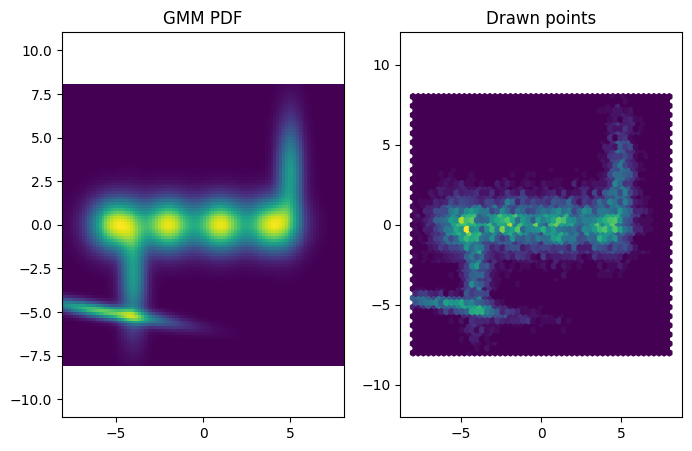

In [39]:
def check_problem3():
    """
    Draw a sample of 10,000 points from the GMM defined in the lab pdf. Plot a heatmap
    of the pdf of the GMM (using plt.pcolormesh) and a hexbin plot of the drawn points.
    How do the plots compare?
    """
    # Define the GMM
    gmm = GMM(n_components=7,
        weights=np.array([0.175, 0.175, 0.175, .175, .1, .1, .1]),
        means=np.array([[-5, 0], [-2, 0], [1, 0], [4, 0], [-4, -3], [5, 3], [-5.5, -5]]),   # [-4,-2],[-5,-5]
        covars=np.array([
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[1, 0], [0, 1]],
            [[0.25, 0], [0, 4]],
            [[0.25, 0], [0, 4]],
            [[6, -1], [-1, .25]]# [[2, -20],[0, .25]]#[[0.25, -1],[-1, 8]],[[.25,-2],[-1,2]]
        ]))
        
    points = gmm.draw(10_000)
    
    plt.figure(figsize=(8, 5))
    # PDF
    x = np.linspace(-8, 8, 100)
    y = np.linspace(-8, 8, 100)
    X, Y = np.meshgrid(x, y)
    Z = gmm.pdf(np.dstack((X, Y)))
    
    plt.subplot(1, 2, 1)
    plt.pcolormesh(X, Y, Z)
    plt.axis('equal')
    plt.title("GMM PDF")
    
    # Hexbin
    plt.subplot(1, 2, 2)
    plt.hexbin(points[:, 0], points[:, 1], extent=(-8, 8, -8, 8), gridsize=50)
    plt.axis('equal')
    plt.title("Drawn points")
    
    plt.show()
    
check_problem3()

### Check for problem 4

In [40]:
def check_problem4():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    correct = np.array([[3.49810771e-06, 5.30334386e-05, 9.99997070e-01],
                     [9.99996502e-01, 9.99946967e-01, 2.93011749e-06]])
    
    print(gmm._compute_e_step(data))
    print(np.allclose(gmm._compute_e_step(data), correct))
    
check_problem4()

[[3.49810771e-06 5.30334386e-05 9.99997070e-01]
 [9.99996502e-01 9.99946967e-01 2.93011749e-06]]
True


In [41]:
def check_problem5():
    gmm = init_gmm()

    data = np.array([
        [0.5, 1.0],
        [1.0, 0.5],
        [-2.0, 0.7]
        ])
    
    cor_w, cor_mus, cor_sigs = (np.array([0.3333512, 0.6666488]),
                              np.array([[-1.99983216, 0.69999044], [0.74998978, 0.75000612]]),
                              np.array([[[4.99109197e-04, -2.91933135e-05], 
                                         [-2.91933135e-05, 2.43594533e-06]],
                                        [[6.25109881e-02, -6.24997069e-02], 
                                         [-6.24997069e-02, 6.24999121e-02]]]))
    print(np.allclose(gmm._compute_m_step(data)[0], cor_w))
    
check_problem5()

True


Time to train: 0.056842332996893674


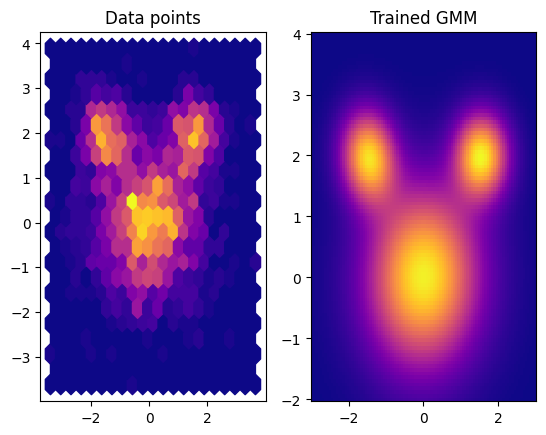

In [42]:
def check_problem6(filename='./Data/gmm_data.npy'):
    """
    The file problem6.npy contains a collection of data drawn from a GMM.
    Train a GMM on this data with n_components=3. Plot the pdf of your
    trained GMM, as well as a hexbin plot of the data.
    """
    data = np.load(filename)
    
    start = time.perf_counter()
    ################################# YOU WRITE CODE HERE ##########################################
    # Train the GMM !Call the variable gmm so this rest of the code works!
    
    # gmm = intialize with 3 components and fit 'data'
    gmm = GMM(n_components=3)
    gmm.fit(data)
    
    ################################################################################################
    end = time.perf_counter()

    
    # Plot the pdf and a hexbin
    x = np.linspace(-3, 3, 100)
    y = np.linspace(-2, 4, 100)
    X, Y = np.meshgrid(x, y)
    XY = np.dstack((X, Y))
    
    # Plot the data points
    plt.subplot(1, 2, 1)
    plt.hexbin(data[:, 0], data[:, 1], gridsize=20, cmap='plasma')
    plt.title("Data points")
    
    plt.subplot(1, 2, 2)
    plt.pcolormesh(X, Y, gmm.pdf(XY), shading='auto', cmap='plasma')
    plt.title("Trained GMM")
    
    print(f"Time to train: {end-start}")
    plt.show()
    
check_problem6()

Time to train: 0.10211462498409674


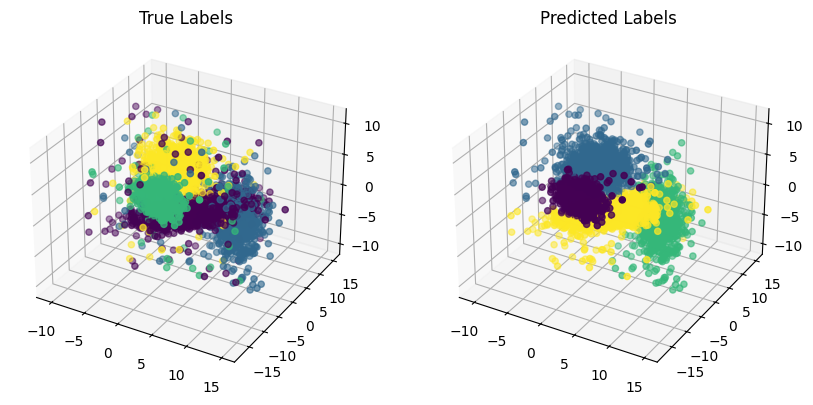

Accuracy: 0.9056


In [43]:
def get_accuracy(pred_y, true_y):
    """
    Helper function to calculate the actually clustering accuracy, accounting for
    the possibility that labels are permuted.
    
    This computes the confusion matrix and uses scipy's implementation of the Hungarian
    Algorithm (linear_sum_assignment) to find the best combination, which is generally
    much faster than directly checking the permutations.
    """
    # Compute confusion matrix
    cm = confusion_matrix(pred_y, true_y)
    # Find the arrangement that maximizes the score
    r_ind, c_ind = linear_sum_assignment(cm, maximize=True)
    return np.sum(cm[r_ind, c_ind]) / np.sum(cm)
    
def problem7(filename='./Data/classification.npz'):
    """
    The file classification.npz contains a set of 3-dimensional data points "X" and 
    their labels "y". Use your class with n_components=4 to cluster the data.
    Plot the points with the predicted and actual labels, and compute and return
    your model's accuracy. Be sure to check for permuted labels.
    
    Returns:
        (float) - the GMM's accuracy on the dataset
    """
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Train the GMM
    gmm = GMM(n_components=4)
    
    # Timing how long it takes to train
    start = time.perf_counter()
    pred_y = gmm.fit_predict(X)
    end = time.perf_counter()

    print(f"Time to train: {end-start}")

    # Plot the 3D Data points
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=true_y, cmap='viridis')
    ax.set_title("True Labels")

    ax = fig.add_subplot(122, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=pred_y, cmap='viridis')
    ax.set_title("Predicted Labels")
    plt.show()

    # Compute the accuracy
    return get_accuracy(pred_y, true_y)

print("Accuracy: " + str(problem7()))

In [44]:
def method_comparison(filename='./Data/classification.npz'):
    """
    Again using classification.npz, compare your class, sklearn's GMM implementation, 
    and sklearn's K-means implementation for speed of training and for accuracy of 
    the resulting clusters. Print your results. Be sure to check for permuted labels.
    """
    # Load the data
    data = np.load(filename)
    X, true_y = data['X'], data['y']
    
    # Our class
    start = time.perf_counter()
    gmm = GMM(n_components=4).fit(X)
    end = time.perf_counter()
    gmm_pred = gmm.predict(X)
    gmm_time = end - start
    gmm_acc = get_accuracy(true_y, gmm_pred)
    
    # sklearn GMM
    start = time.perf_counter()
    sk_gmm = GaussianMixture(n_components=4).fit(X)
    end = time.perf_counter()
    sk_gmm_pred = sk_gmm.predict(X)
    sk_gmm_time = end - start
    sk_gmm_acc = get_accuracy(true_y, sk_gmm_pred)
    
    # sklearn K-means
    start = time.perf_counter()
    sk_km = KMeans(n_clusters=4).fit(X)
    end = time.perf_counter()
    sk_km_pred = sk_km.predict(X)
    sk_km_time = end - start
    sk_km_acc = get_accuracy(true_y, sk_km_pred)
    
    print("Our GMM class:")
    print(f"\tAccuracy: {gmm_acc:.4f}")
    print(f"\tTrain time: {gmm_time:.6f} s")
    
    print("sklearn GMM:")
    print(f"\tAccuracy: {sk_gmm_acc:.4f}")
    print(f"\tTrain time: {sk_gmm_time:.6f} s")
    
    print("sklearn K-means:")
    print(f"\tAccuracy: {sk_km_acc:.4f}")
    print(f"\tTrain time: {sk_km_time:.6f} s")
    
method_comparison()

Our GMM class:
	Accuracy: 0.8806
	Train time: 0.147999 s
sklearn GMM:
	Accuracy: 0.8926
	Train time: 0.027323 s
sklearn K-means:
	Accuracy: 0.7582
	Train time: 0.003013 s
